# 1.Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras import regularizers

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
XL=pd.read_csv('9_5day_resampled.csv')
#XU_train=pd.read_csv('9_510_U_resample_5_95.csv')# No resampling done in the unlabeled set, It just denotes the pair of L and U

In [4]:
from sklearn.utils import shuffle
#XU_train.head()

In [5]:
XL.head()

,Source.IP,Source.Port,Destination.IP,Destination.Port,Protocol,Timestamp,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,Fwd.Packet.Length.Max,...,min_seg_size_forward,Active.Mean,Active.Std,Active.Max,Active.Min,Idle.Mean,Idle.Std,Idle.Max,Idle.Min,ProtocolName
0,180881369,38752,874422793,80,6,1.494318e+09,86,1,1,0,...,32,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,AMAZON
1,180881347,60112,921084361,80,6,1.494322e+09,117939538,214,242,541,...,32,2104280.0,43740.211271,2135209.0,2073351.0,26398694.5,993864.743909,27101463.0,25695926.0,AMAZON
2,180881370,45916,915964343,80,6,1.494318e+09,101,1,1,0,...,32,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,AMAZON
3,180881370,45075,915964343,80,6,1.494317e+09,140,1,1,0,...,32,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,AMAZON
4,180881370,43447,872483344,80,6,1.494318e+09,118,1,1,0,...,32,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,AMAZON


In [8]:
a=XL.groupby('ProtocolName')['ProtocolName'].count().sort_values(ascending=False)


In [9]:
a   # see resampled instances

ProtocolName
YOUTUBE           6000
SSL               6000
GOOGLE            6000
HTTP              6000
HTTP_CONNECT      6000
HTTP_PROXY        6000
AMAZON            6000
GMAIL             5330
MICROSOFT         5285
EDONKEY           5000
HTTP_DOWNLOAD     5000
WHATSAPP          5000
WIKIPEDIA         5000
H323              5000
GOOGLE_MAPS       5000
WINDOWS_UPDATE    5000
FTP_DATA          5000
FACEBOOK          5000
EBAY              5000
INSTAGRAM         5000
EASYTAXI          5000
DROPBOX           5000
DNS               5000
CONTENT_FLASH     5000
CLOUDFLARE        5000
CITRIX_ONLINE     5000
APPLE_ITUNES      5000
APPLE_ICLOUD      5000
APPLE             5000
UPNP              5000
TWITTER           5000
TOR               5000
RTMP              5000
TEAMVIEWER        5000
TEAMSPEAK         5000
STARCRAFT         5000
SSL_NO_CERT       5000
UBUNTUONE         5000
SSH               5000
SPOTIFY           5000
SKYPE             5000
SIMET             5000
OSCAR             500

In [10]:
len(a)

54

In [11]:
from keras.layers import Input, Dense
from keras.models import Model
import keras.backend as K
import tensorflow as tf
from tensorflow.keras import regularizers
from keras.models import load_model
import keras
from keras.layers import Dropout

Using TensorFlow backend.


In [12]:
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.optimizers import Adagrad
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder

In [14]:
yL_train=XL.iloc[:,-1]
XL_train=XL.iloc[:,:-1]

In [15]:
yL_train=pd.get_dummies(yL_train)#One-hot_encoding

# Split into train,test and val

#randomly split into train(80%) and val(20%)
XL_train,XL_val,yL_train,yL_val=train_test_split(XL_train,yL_train,random_state=0,test_size=0.2)

#randomly split val into val(10%) and test(10%)
XL_val,XL_test,yL_val,yL_test=train_test_split(XL_val,yL_val,random_state=0,test_size=0.5)

In [57]:
#different test set
dummy = (yL_test.head(pd.read_csv('yL_test_95U-5L.csv').shape[0])*0).reset_index(drop=True)
ytest = pd.read_csv('yL_test_95U-5L.csv')

In [58]:
#dummy converts 24-one hot encoded classes into 54-one hot encoded classes
for i in yL_test.columns:
    if i in ytest.columns:
        dummy[i] = ytest[i]

In [61]:
yL_test = dummy
XL_test = pd.read_csv('XL_test_95U-5L.csv')

 Reversing the one hot encoding for each set to be used for ML methods

In [62]:
yL_train2=yL_train[yL_train==1].stack().reset_index().drop(0,1)['level_1'] # reversing the one hot encoding for each set

In [63]:
yL_val2=yL_val[yL_val==1].stack().reset_index().drop(0,1)['level_1']# reversing the one hot encoding for each set

In [64]:
yL_test2=yL_test[yL_test==1].stack().reset_index().drop(0,1)['level_1']# reversing the one hot encoding for each set

In [66]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

#scaling and normalization
scaler=StandardScaler()
#XU_train=scaler.fit_transform(XU_train)
XL_train=scaler.fit_transform(XL_train)
XL_val=scaler.transform(XL_val)
XL_test=scaler.transform(XL_test)


# 2. Training the SDAE
#### Training the Encoder parts

In [67]:
from keras_sequential_ascii import keras2ascii
from tensorflow.keras import regularizers
from keras.models import Sequential

In [68]:
from keras import backend as K
import time

In [69]:
#Train Sparse Stacked Denoising Autoencoder
#layers = [100,200,400,50]
#activations=['relu','relu','relu','relu']
#rho=[0.06,0.06,0.06,0.06]
#traint0=time.time()
#stacked_layers=SDAE(XU_train,layers,activations,rho,10,'mask',0.02)


model=Sequential()
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.02))
model.add(Dense(200,activation='relu'))
model.add(Dropout(0.02))
model.add(Dense(400,activation='relu'))
model.add(Dropout(0.02))
model.add(Dense(50,activation='relu'))
model.add(Dense(len(yL_train.columns),activation='softmax'))
model.layers

### Please skip this section to part 6 If only ML methods are to be tested, The following is the DL NN model

In [70]:
model.compile(optimizer=RMSprop(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [71]:
#fine tune model runs for no. of epochs set below
train0 = time.time()
history=model.fit(XL_train,np.array(yL_train),
                epochs=750,
                batch_size=256,
                shuffle=True,
                validation_data=(XL_val, np.array(yL_val)),
                )
traint1=time.time()

Train on 222092 samples, validate on 27761 samples
Epoch 1/750
222092/222092 [==============================] - 11s 51us/step - loss: 2.7371 - accuracy: 0.3553 - val_loss: 2.0514 - val_accuracy: 0.4912
Epoch 2/750
222092/222092 [==============================] - 10s 45us/step - loss: 1.8643 - accuracy: 0.5217 - val_loss: 1.6842 - val_accuracy: 0.5621
Epoch 3/750
222092/222092 [==============================] - 10s 46us/step - loss: 1.6313 - accuracy: 0.5705 - val_loss: 1.5250 - val_accuracy: 0.5969
Epoch 4/750
222092/222092 [==============================] - 11s 48us/step - loss: 1.5063 - accuracy: 0.5979 - val_loss: 1.4211 - val_accuracy: 0.6241
Epoch 5/750
222092/222092 [==============================] - 10s 44us/step - loss: 1.4199 - accuracy: 0.6178 - val_loss: 1.3415 - val_accuracy: 0.6301
Epoch 6/750
222092/222092 [==============================] - 10s 46us/step - loss: 1.3533 - accuracy: 0.6320 - val_loss: 1.2843 - val_accuracy: 0.6525
Epoch 7/750
222092/222092 [================

Epoch 55/750
222092/222092 [==============================] - 7s 33us/step - loss: 0.7196 - accuracy: 0.7854 - val_loss: 0.6667 - val_accuracy: 0.8032
Epoch 56/750
222092/222092 [==============================] - 7s 34us/step - loss: 0.7142 - accuracy: 0.7875 - val_loss: 0.6658 - val_accuracy: 0.8025
Epoch 57/750
222092/222092 [==============================] - 7s 33us/step - loss: 0.7099 - accuracy: 0.7873 - val_loss: 0.6591 - val_accuracy: 0.8056
Epoch 58/750
222092/222092 [==============================] - 7s 33us/step - loss: 0.7079 - accuracy: 0.7878 - val_loss: 0.6572 - val_accuracy: 0.8071
Epoch 59/750
222092/222092 [==============================] - 7s 33us/step - loss: 0.7041 - accuracy: 0.7892 - val_loss: 0.6562 - val_accuracy: 0.8052
Epoch 60/750
222092/222092 [==============================] - 7s 33us/step - loss: 0.6997 - accuracy: 0.7907 - val_loss: 0.6521 - val_accuracy: 0.8089
Epoch 61/750
222092/222092 [==============================] - 7s 33us/step - loss: 0.6954 - ac

222092/222092 [==============================] - 8s 36us/step - loss: 0.5755 - accuracy: 0.8236 - val_loss: 0.5467 - val_accuracy: 0.8363
Epoch 110/750
222092/222092 [==============================] - 8s 37us/step - loss: 0.5735 - accuracy: 0.8249 - val_loss: 0.5461 - val_accuracy: 0.8349
Epoch 111/750
222092/222092 [==============================] - 8s 37us/step - loss: 0.5735 - accuracy: 0.8250 - val_loss: 0.5442 - val_accuracy: 0.8369
Epoch 112/750
222092/222092 [==============================] - 8s 36us/step - loss: 0.5705 - accuracy: 0.8248 - val_loss: 0.5468 - val_accuracy: 0.8359
Epoch 113/750
222092/222092 [==============================] - 8s 35us/step - loss: 0.5701 - accuracy: 0.8254 - val_loss: 0.5426 - val_accuracy: 0.8375
Epoch 114/750
222092/222092 [==============================] - 8s 35us/step - loss: 0.5676 - accuracy: 0.8263 - val_loss: 0.5402 - val_accuracy: 0.8378
Epoch 115/750
222092/222092 [==============================] - 8s 36us/step - loss: 0.5655 - accuracy:

Epoch 163/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.5022 - accuracy: 0.8444 - val_loss: 0.4897 - val_accuracy: 0.8529
Epoch 164/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.5018 - accuracy: 0.8446 - val_loss: 0.4933 - val_accuracy: 0.8513
Epoch 165/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.5014 - accuracy: 0.8454 - val_loss: 0.4905 - val_accuracy: 0.8524
Epoch 166/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.5006 - accuracy: 0.8445 - val_loss: 0.4862 - val_accuracy: 0.8527
Epoch 167/750
222092/222092 [==============================] - 7s 31us/step - loss: 0.5005 - accuracy: 0.8451 - val_loss: 0.4879 - val_accuracy: 0.8535
Epoch 168/750
222092/222092 [==============================] - 7s 31us/step - loss: 0.4974 - accuracy: 0.8461 - val_loss: 0.4889 - val_accuracy: 0.8531
Epoch 169/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.49

Epoch 217/750
222092/222092 [==============================] - 7s 31us/step - loss: 0.4567 - accuracy: 0.8566 - val_loss: 0.4601 - val_accuracy: 0.8618
Epoch 218/750
222092/222092 [==============================] - 7s 34us/step - loss: 0.4557 - accuracy: 0.8575 - val_loss: 0.4590 - val_accuracy: 0.8626
Epoch 219/750
222092/222092 [==============================] - 8s 34us/step - loss: 0.4553 - accuracy: 0.8585 - val_loss: 0.4595 - val_accuracy: 0.8602
Epoch 220/750
222092/222092 [==============================] - 7s 33us/step - loss: 0.4545 - accuracy: 0.8581 - val_loss: 0.4569 - val_accuracy: 0.8616
Epoch 221/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.4538 - accuracy: 0.8581 - val_loss: 0.4582 - val_accuracy: 0.8621
Epoch 222/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.4533 - accuracy: 0.8583 - val_loss: 0.4555 - val_accuracy: 0.8624
Epoch 223/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.45

Epoch 271/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.4235 - accuracy: 0.8667 - val_loss: 0.4368 - val_accuracy: 0.8688
Epoch 272/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.4214 - accuracy: 0.8670 - val_loss: 0.4387 - val_accuracy: 0.8682
Epoch 273/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.4226 - accuracy: 0.8669 - val_loss: 0.4390 - val_accuracy: 0.8686
Epoch 274/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.4220 - accuracy: 0.8667 - val_loss: 0.4348 - val_accuracy: 0.8693
Epoch 275/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.4211 - accuracy: 0.8669 - val_loss: 0.4372 - val_accuracy: 0.8681
Epoch 276/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.4205 - accuracy: 0.8670 - val_loss: 0.4377 - val_accuracy: 0.8682
Epoch 277/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.42

Epoch 325/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.3982 - accuracy: 0.8744 - val_loss: 0.4221 - val_accuracy: 0.8734
Epoch 326/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.3965 - accuracy: 0.8742 - val_loss: 0.4257 - val_accuracy: 0.8740
Epoch 327/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.3974 - accuracy: 0.8742 - val_loss: 0.4257 - val_accuracy: 0.8708
Epoch 328/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.3990 - accuracy: 0.8738 - val_loss: 0.4241 - val_accuracy: 0.8742
Epoch 329/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.3972 - accuracy: 0.8738 - val_loss: 0.4217 - val_accuracy: 0.8742
Epoch 330/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.3952 - accuracy: 0.8745 - val_loss: 0.4217 - val_accuracy: 0.8736
Epoch 331/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.39

Epoch 379/750
222092/222092 [==============================] - 7s 31us/step - loss: 0.3756 - accuracy: 0.8800 - val_loss: 0.4121 - val_accuracy: 0.8776
Epoch 380/750
222092/222092 [==============================] - 7s 31us/step - loss: 0.3757 - accuracy: 0.8804 - val_loss: 0.4183 - val_accuracy: 0.8761
Epoch 381/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.3761 - accuracy: 0.8808 - val_loss: 0.4143 - val_accuracy: 0.8764
Epoch 382/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.3742 - accuracy: 0.8808 - val_loss: 0.4222 - val_accuracy: 0.8762
Epoch 383/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.3761 - accuracy: 0.8796 - val_loss: 0.4136 - val_accuracy: 0.8780
Epoch 384/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.3742 - accuracy: 0.8807 - val_loss: 0.4154 - val_accuracy: 0.8771
Epoch 385/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.37

Epoch 433/750
222092/222092 [==============================] - 8s 34us/step - loss: 0.3555 - accuracy: 0.8860 - val_loss: 0.4030 - val_accuracy: 0.8826
Epoch 434/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.3563 - accuracy: 0.8858 - val_loss: 0.4034 - val_accuracy: 0.8803
Epoch 435/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.3545 - accuracy: 0.8869 - val_loss: 0.4053 - val_accuracy: 0.8831
Epoch 436/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.3559 - accuracy: 0.8863 - val_loss: 0.4043 - val_accuracy: 0.8822
Epoch 437/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.3535 - accuracy: 0.8862 - val_loss: 0.4083 - val_accuracy: 0.8806
Epoch 438/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.3527 - accuracy: 0.8866 - val_loss: 0.4048 - val_accuracy: 0.8816
Epoch 439/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.35

Epoch 487/750
222092/222092 [==============================] - 8s 34us/step - loss: 0.3391 - accuracy: 0.8907 - val_loss: 0.3927 - val_accuracy: 0.8855
Epoch 488/750
222092/222092 [==============================] - 7s 33us/step - loss: 0.3366 - accuracy: 0.8910 - val_loss: 0.3957 - val_accuracy: 0.8845
Epoch 489/750
222092/222092 [==============================] - 7s 33us/step - loss: 0.3363 - accuracy: 0.8917 - val_loss: 0.3947 - val_accuracy: 0.8859
Epoch 490/750
222092/222092 [==============================] - 8s 34us/step - loss: 0.3366 - accuracy: 0.8910 - val_loss: 0.3957 - val_accuracy: 0.8846
Epoch 491/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.3376 - accuracy: 0.8913 - val_loss: 0.3983 - val_accuracy: 0.8857
Epoch 492/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.3354 - accuracy: 0.8914 - val_loss: 0.3941 - val_accuracy: 0.8854
Epoch 493/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.33

Epoch 541/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.3246 - accuracy: 0.8950 - val_loss: 0.3937 - val_accuracy: 0.8857
Epoch 542/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.3223 - accuracy: 0.8955 - val_loss: 0.3896 - val_accuracy: 0.8888
Epoch 543/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.3213 - accuracy: 0.8961 - val_loss: 0.3857 - val_accuracy: 0.8900
Epoch 544/750
222092/222092 [==============================] - 7s 31us/step - loss: 0.3226 - accuracy: 0.8958 - val_loss: 0.3922 - val_accuracy: 0.8879
Epoch 545/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.3232 - accuracy: 0.8953 - val_loss: 0.3894 - val_accuracy: 0.8891
Epoch 546/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.3222 - accuracy: 0.8958 - val_loss: 0.3908 - val_accuracy: 0.8887
Epoch 547/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.31

Epoch 595/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.3124 - accuracy: 0.8990 - val_loss: 0.3919 - val_accuracy: 0.8877
Epoch 596/750
222092/222092 [==============================] - 7s 31us/step - loss: 0.3132 - accuracy: 0.8985 - val_loss: 0.3820 - val_accuracy: 0.8911
Epoch 597/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.3109 - accuracy: 0.8991 - val_loss: 0.3897 - val_accuracy: 0.8896
Epoch 598/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.3107 - accuracy: 0.8992 - val_loss: 0.3895 - val_accuracy: 0.8879
Epoch 599/750
222092/222092 [==============================] - 7s 34us/step - loss: 0.3132 - accuracy: 0.8984 - val_loss: 0.3869 - val_accuracy: 0.8890
Epoch 600/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.3102 - accuracy: 0.8994 - val_loss: 0.3918 - val_accuracy: 0.8888
Epoch 601/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.31

Epoch 649/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.3026 - accuracy: 0.9020 - val_loss: 0.3889 - val_accuracy: 0.8903
Epoch 650/750
222092/222092 [==============================] - 7s 31us/step - loss: 0.3027 - accuracy: 0.9022 - val_loss: 0.3886 - val_accuracy: 0.8904
Epoch 651/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.3028 - accuracy: 0.9018 - val_loss: 0.3943 - val_accuracy: 0.8896
Epoch 652/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.3010 - accuracy: 0.9026 - val_loss: 0.3857 - val_accuracy: 0.8913
Epoch 653/750
222092/222092 [==============================] - 7s 31us/step - loss: 0.3015 - accuracy: 0.9024 - val_loss: 0.3881 - val_accuracy: 0.8911
Epoch 654/750
222092/222092 [==============================] - 7s 32us/step - loss: 0.3021 - accuracy: 0.9021 - val_loss: 0.3872 - val_accuracy: 0.8905
Epoch 655/750
222092/222092 [==============================] - 7s 31us/step - loss: 0.30

Epoch 703/750
222092/222092 [==============================] - 8s 35us/step - loss: 0.2951 - accuracy: 0.9045 - val_loss: 0.3873 - val_accuracy: 0.8921
Epoch 704/750
222092/222092 [==============================] - 8s 37us/step - loss: 0.2946 - accuracy: 0.9038 - val_loss: 0.3825 - val_accuracy: 0.8928
Epoch 705/750
222092/222092 [==============================] - 8s 35us/step - loss: 0.2945 - accuracy: 0.9048 - val_loss: 0.3871 - val_accuracy: 0.8917
Epoch 706/750
222092/222092 [==============================] - 8s 36us/step - loss: 0.2934 - accuracy: 0.9041 - val_loss: 0.3905 - val_accuracy: 0.8913
Epoch 707/750
222092/222092 [==============================] - 7s 33us/step - loss: 0.2949 - accuracy: 0.9038 - val_loss: 0.3916 - val_accuracy: 0.8907
Epoch 708/750
222092/222092 [==============================] - 8s 36us/step - loss: 0.2950 - accuracy: 0.9041 - val_loss: 0.3824 - val_accuracy: 0.8932
Epoch 709/750
222092/222092 [==============================] - 9s 41us/step - loss: 0.29

In [72]:
print("Train_time: "+str(traint1-train0))

Train_time: 5538.420938253403


In [171]:
test0=time.time()
print(model.evaluate(XL_test,yL_test))
test1=time.time()
print("Test_time: "+str(test1-test0))

12037/12037 [==============================] - 0s 36us/step
[0.6320622467148925, 0.8112486600875854]
Test_time: 0.3402100673675537


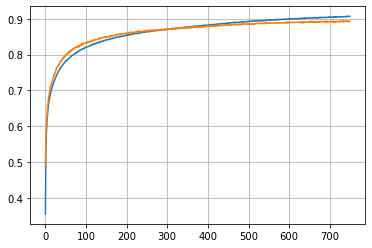

In [74]:
#Visualise convergence with no. of epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid()

# 5. Results
#### Below are the results obtained on our NN model

In [75]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [76]:
y_pred=model.predict(XL_test)

In [79]:
y_pred1=y_pred.argmax(axis=1)
y_pred1=np.append(y_pred1,np.arange(54))
y_pred1=pd.get_dummies(y_pred1,columns=yL_train.columns)
y_pred1.columns=yL_test.columns
y_pred1=y_pred1.iloc[:-54]

In [80]:
yL_test.sum()

AMAZON            500
APPLE             474
APPLE_ICLOUD        0
APPLE_ITUNES      515
CITRIX_ONLINE       0
CLOUDFLARE        461
CONTENT_FLASH     494
DNS                 0
DROPBOX           487
EASYTAXI            0
EBAY              508
EDONKEY             0
FACEBOOK          473
FTP_DATA            0
GMAIL             501
GOOGLE            550
GOOGLE_MAPS         0
H323                0
HTTP              491
HTTP_CONNECT      490
HTTP_DOWNLOAD       0
HTTP_PROXY        533
INSTAGRAM           0
IP_ICMP             0
IP_OSPF             0
LASTFM              0
MICROSOFT         497
MQTT                0
MSN               497
MSSQL               0
MS_ONE_DRIVE        0
NETFLIX             0
NTP                 0
OFFICE_365        522
OSCAR               0
RTMP                0
SIMET               0
SKYPE             491
SPOTIFY             0
SSH                 0
SSL               517
SSL_NO_CERT         0
STARCRAFT           0
TEAMSPEAK           0
TEAMVIEWER          0
TOR       

In [81]:
y_test1 = yL_test.columns[np.where(yL_test!=0)[1]]

In [82]:
y_pred1=y_pred1.columns[np.where(y_pred1!=0)[1]]
y_pred1

Index(['WINDOWS_UPDATE', 'APPLE', 'APPLE_ITUNES', 'OFFICE_365', 'MICROSOFT',
       'WIKIPEDIA', 'CLOUDFLARE', 'NETFLIX', 'EBAY', 'MSN',
       ...
       'WINDOWS_UPDATE', 'YAHOO', 'HTTP_CONNECT', 'GMAIL', 'HTTP', 'MSN',
       'YAHOO', 'TWITTER', 'WHATSAPP', 'SKYPE'],
      dtype='object', length=12037)

In [83]:
cm=confusion_matrix(y_test1,y_pred1,labels=yL_test.columns)

In [84]:
cm_pc=pd.DataFrame((cm.T/np.sum(cm,axis=1)).T,columns=yL_test.columns,index=yL_test.columns)
cm_pc=cm_pc.replace(np.nan,0)


c:\users\dhruvjyoti\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


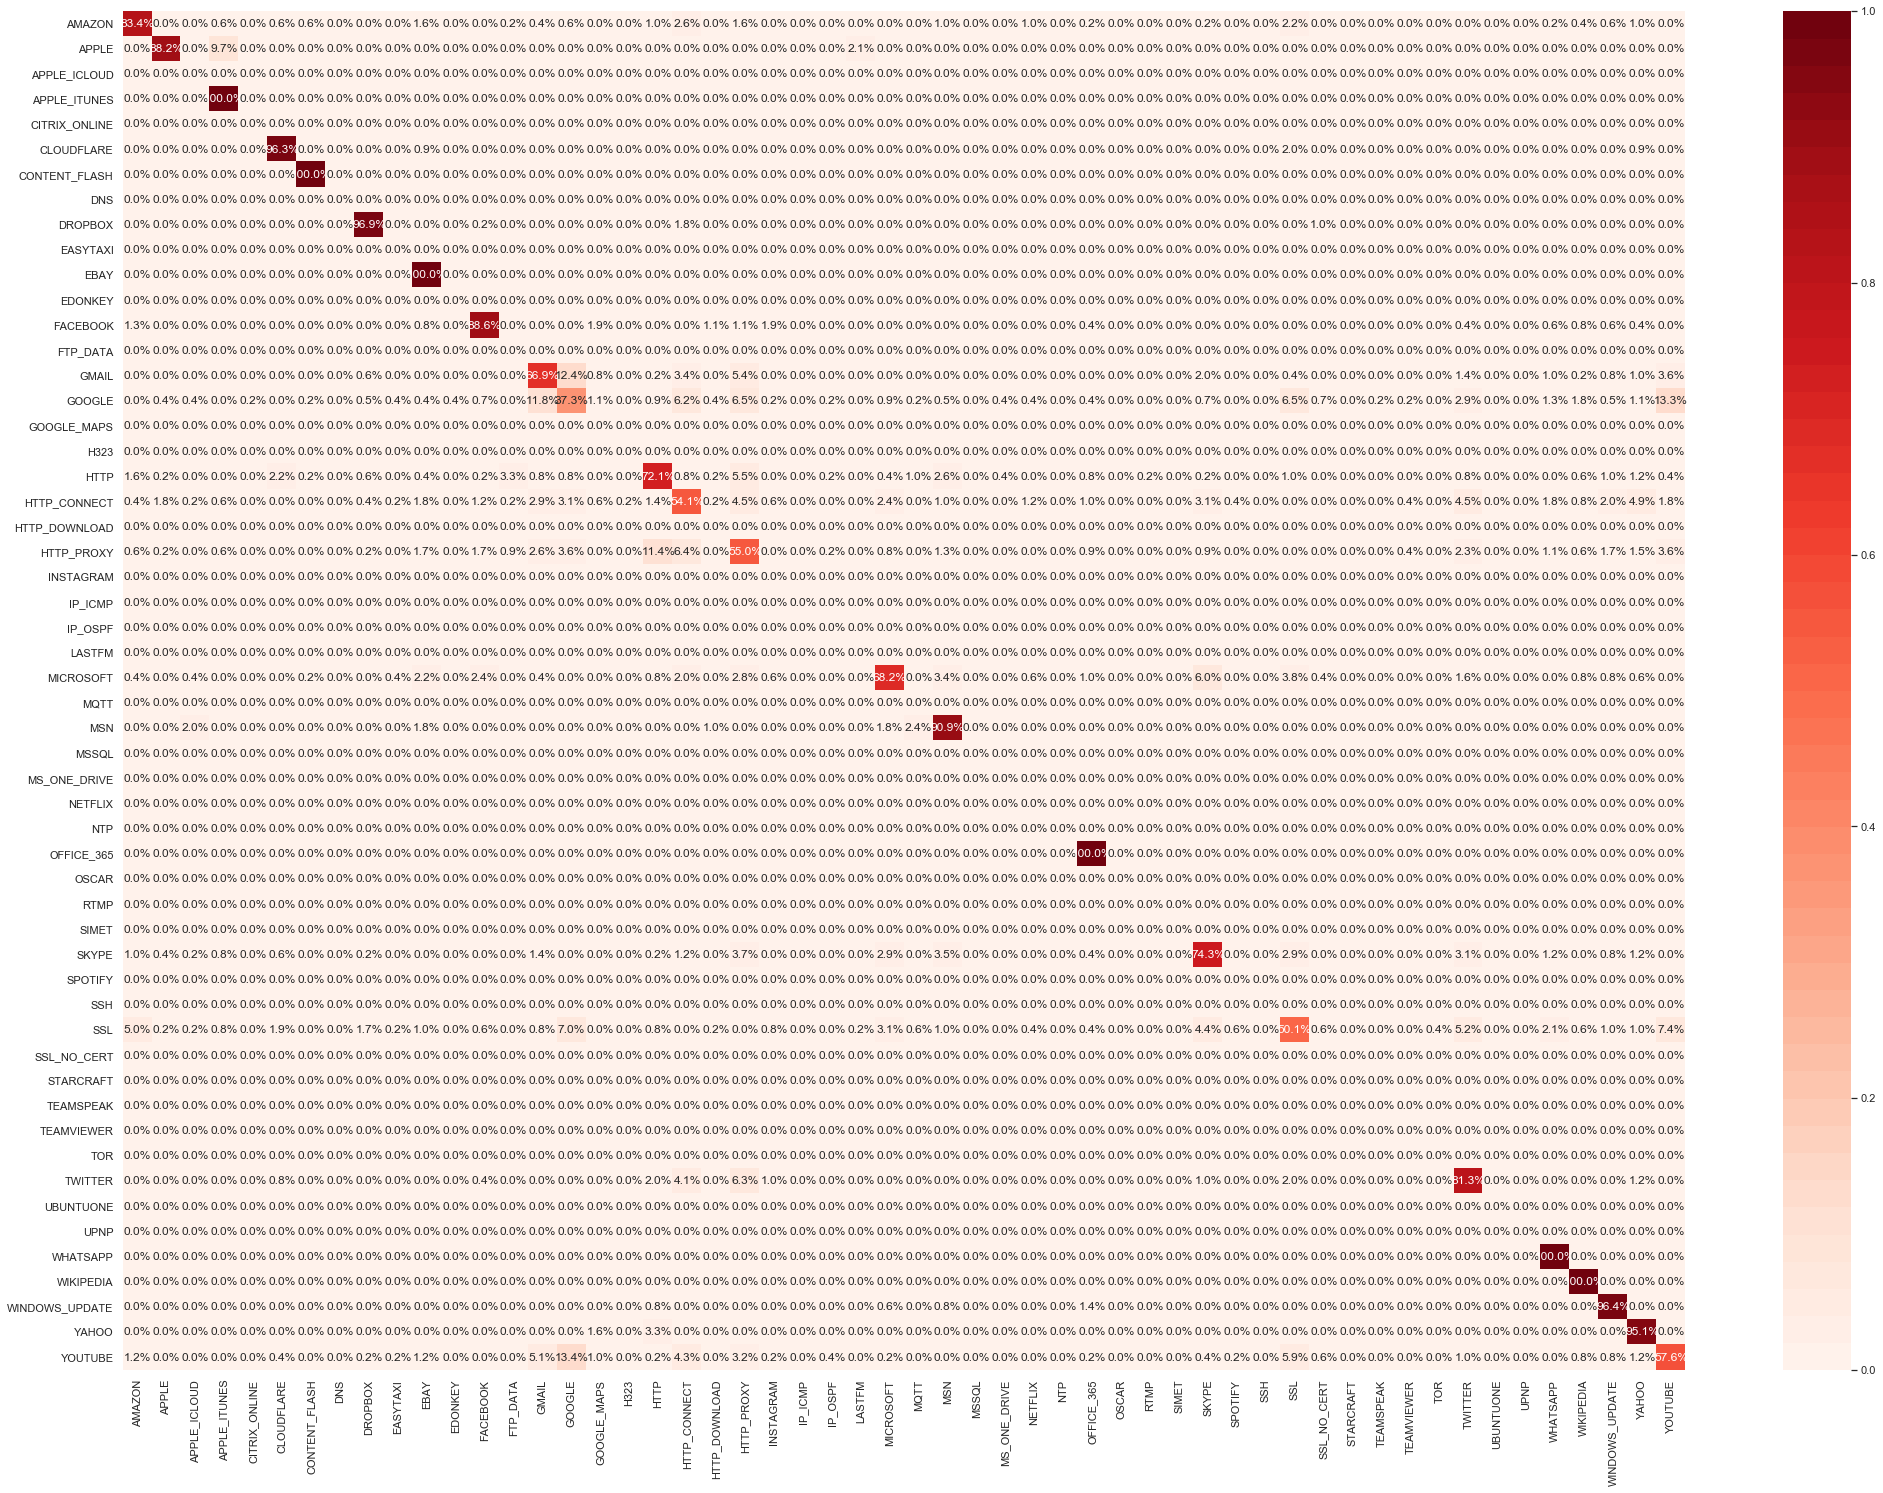

In [85]:
# Plot confusion matrix
plt.figure(figsize=(35,25))
df_cm=pd.DataFrame(cm,columns=yL_test.columns,index=yL_test.columns)
sns.set(font_scale=1.0)
sns.heatmap(cm_pc, annot=True,fmt='.1%',cmap=sns.color_palette("Reds",50)) # font size
plt.show()

In [86]:
print('Test Accuracy : '+str(accuracy_score(y_test1, y_pred1)))

Test Accuracy : 0.8112486499958461


In [88]:
print('weighted F1 Score : ' + str(f1_score(y_pred1,y_test1,average = 'weighted')))
print('Macro F1 Score : ' + str(f1_score(y_pred1,y_test1,average = 'macro')))
print('Micro F1 Score : ' + str(f1_score(y_pred1,y_test1,average = 'micro')))
print('F1 Scores : ' )
pd.DataFrame(f1_score(y_pred1,y_test1,labels=yL_test.columns,average = None),columns=['F1-score'],index=yL_test.columns)

weighted F1 Score : 0.8110271063894944
Macro F1 Score : 0.4439780962322351
Micro F1 Score : 0.8112486499958461
F1 Scores : 


,F1-score
AMAZON,0.855385
APPLE,0.920705
APPLE_ICLOUD,0.000000
APPLE_ITUNES,0.942360
CITRIX_ONLINE,0.000000
CLOUDFLARE,0.946695
CONTENT_FLASH,0.993964
DNS,0.000000
DROPBOX,0.961303
EASYTAXI,0.000000


In [89]:
len(yL_train.columns)# No. of distinct labels

54

In [90]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [91]:
print('Weighted Precision : '+str(precision_score(y_test1, y_pred1,average="weighted")))
print('Macro Precision : '+str(precision_score(y_test1, y_pred1,average="macro")))
print('Micro Precision : '+str(precision_score(y_test1, y_pred1,average="micro")))
print('Precision Scores : ' )
pd.DataFrame(precision_score(y_pred1,y_test1,labels=yL_test.columns,average = None),columns=['Precision-score'],index=yL_test.columns)

Weighted Precision : 0.8162284370639037
Macro Precision : 0.4465596540734651
Micro Precision : 0.8112486499958461
Precision Scores : 


c:\users\dhruvjyoti\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Precision-score
AMAZON,0.834000
APPLE,0.881857
APPLE_ICLOUD,0.000000
APPLE_ITUNES,1.000000
CITRIX_ONLINE,0.000000
CLOUDFLARE,0.963124
CONTENT_FLASH,1.000000
DNS,0.000000
DROPBOX,0.969199
EASYTAXI,0.000000


In [92]:
print('Weighted Recall : '+str(recall_score(y_test1, y_pred1,average="weighted")))
print('Macro Recall : '+str(recall_score(y_test1, y_pred1,average="macro")))
print('Micro Recall : '+str(recall_score(y_test1, y_pred1,average="micro")))
print('Recall Scores : ' )
pd.DataFrame(recall_score(y_pred1,y_test1,labels=yL_test.columns,average = None),columns=['recall-score'],index=yL_test.columns)

c:\users\dhruvjyoti\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weighted Recall : 0.8112486499958461
Macro Recall : 0.443814507868657
Micro Recall : 0.8112486499958461
Recall Scores : 


,recall-score
AMAZON,0.877895
APPLE,0.963134
APPLE_ICLOUD,0.000000
APPLE_ITUNES,0.891003
CITRIX_ONLINE,0.000000
CLOUDFLARE,0.930818
CONTENT_FLASH,0.988000
DNS,0.000000
DROPBOX,0.953535
EASYTAXI,0.000000


#### Confusion Matrix with 10 chosen well-known classes
Classes : AMAZON, FACEBOOK, GMAIL, GOOGLE, HTTP, OFFICE_365, SKYPE, TWITTER, WHATSAPP, YOUTUBE

In [93]:
from sklearn.metrics import confusion_matrix
apps=['AMAZON','FACEBOOK','GMAIL','GOOGLE','HTTP','OFFICE_365','SKYPE','TWITTER','WHATSAPP','YOUTUBE']#reporting for these well-known Apps
y_test1[y_test1.isin(apps)]
cm=confusion_matrix(y_test1[y_test1.isin(apps)],y_pred1[y_test1.isin(apps)],labels=y_test1[y_test1.isin(apps)].unique())

In [94]:
cm_pc=pd.DataFrame((cm.T/np.sum(cm,axis=1)).T,columns=y_test1[y_test1.isin(apps)].unique(),index=y_test1[y_test1.isin(apps)].unique())
cm_pc=cm_pc.replace(np.nan,0)

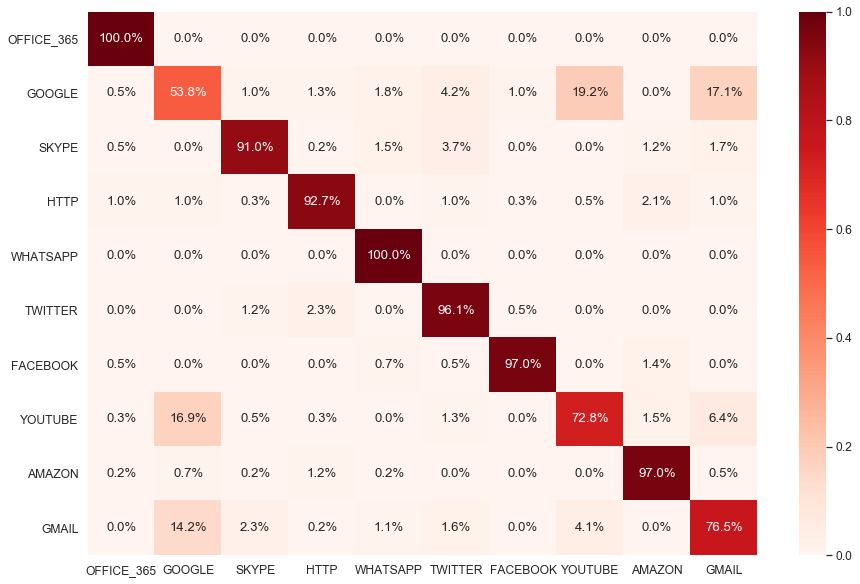

In [95]:
plt.figure(figsize=(15,10))
df_cm=pd.DataFrame(cm,columns=y_test1[y_test1.isin(apps)].unique(),index=y_test1[y_test1.isin(apps)].unique())
sns.set(font_scale=1.1)
sns.heatmap(cm_pc, annot=True,fmt='.1%',cmap=sns.color_palette("Reds",150)) # font size
plt.show()

In [96]:
len(XL)

277615

In [125]:
#restricted Macro scores

y_test_restricted = y_test1[y_pred1.isin(ytest.columns)]
y_pred_restricted = y_pred1[y_pred1.isin(ytest.columns)]

In [126]:
print('Macro F1 : '+str(f1_score(y_test_restricted, y_pred_restricted ,average="macro")))
print('Macro Precision : '+str(precision_score(y_test_restricted, y_pred_restricted ,average="macro")))
print('Macro Recall : '+str(recall_score(y_test_restricted, y_pred_restricted ,average="macro")))

Macro F1 : 0.8208069372020793
Macro Precision : 0.818692699134686
Macro Recall : 0.8267131782293163


In [128]:
model.save('supervised_1')

In [130]:
d = keras.models.load_model('supervised_1')